<h2>Adding imports</h2>

In [40]:
from timeit import timeit
from IPython.display import display
import matplotlib
# matplotlib.use("pgf")
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import cohen_kappa_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
import shap
import seaborn as sns

Open the dataset<br>
The compile_dataset() function reads the dataset from file.<br>
The original datasets contain these features:<br>
timestamp/t (absolute), ID, DLC (some don't have this), data field 0, ..., data field 7, Label.<br>
While compiling the dataset from the loaded files, new features are created.<br>
From the timestamp, "dt" is created, and from timestamp and ID, "dt_ID" is created.<br>
dt is the time between each CAN frame. dt_ID is the time between each CAN frame with the same ID.<br>
From data field 0, ..., data field 7, "ones" is created, and from ID, "ones_ID" is created.<br>
ones is the number of ones counted in the binary payload (combined data fields) for each CAN frame,<br>
and ones_ID is the number of ones counted in the ID for each CAN frame.<br>
Another feature, "type" is also added, which denotes the type of attack that a certain attack is.<br>
For example, flooding (flood), and fuzzing (fuzz).

In [41]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,t,ID,DLC,d0,d1,d2,d3,d4,d5,d6,d7,dt,dt_ID,dataset,type,ones,ones_ID,Label
0,0.000000,608,8,21,30,30,48,0,143,123,44,0.000444,0.009978,Survival,none,27,3,0
1,0.000232,672,8,64,0,118,29,204,4,227,0,0.000232,0.009977,Survival,none,20,3,0
2,0.000480,704,8,20,0,0,0,0,0,0,0,0.000248,0.009981,Survival,none,2,3,0
3,0.000714,809,8,12,185,127,20,17,32,0,20,0.000234,0.009978,Survival,none,21,5,0
4,0.000955,1349,8,216,0,0,140,0,0,0,0,0.000241,0.009978,Survival,none,7,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735835,59.573580,562,8,0,0,0,8,0,0,0,0,0.000248,0.020620,Survival,none,1,4,0
1735836,59.573815,398,8,0,0,0,105,166,154,6,154,0.000235,0.013305,Survival,none,18,5,0
1735837,59.574057,401,8,6,154,6,170,6,154,0,0,0.000242,0.013092,Survival,none,18,4,0
1735838,59.574492,199,4,0,7,2,32,0,0,0,0,0.000435,0.012329,Survival,none,5,5,0


Drop a few columns<br>
The data fields are dropped because there are different standards for each car manufacturers<br>
on how to use the bytes in the payload of the CAN frame.<br>
The ID is dropped for the same reason as the data fields; manufacturers use different high level protocols<br>
to encode the ID field in their vehicles. Also, some datasets obfuscate their data.
DLC is dropped because it does not exist in all datasets.<br>
t is dropped because the absolute timestamps will not give much information, because<br>
data dathered on different times will vary a lot. The delta time (dt) is better in this regard.<br>

In [42]:
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7", "ID", "DLC", "t"], inplace=True, errors="ignore")

display(df)

,dt,dt_ID,dataset,type,ones,ones_ID,Label
0,0.000444,0.009978,Survival,none,27,3,0
1,0.000232,0.009977,Survival,none,20,3,0
2,0.000248,0.009981,Survival,none,2,3,0
3,0.000234,0.009978,Survival,none,21,5,0
4,0.000241,0.009978,Survival,none,7,5,0
...,...,...,...,...,...,...,...
1735835,0.000248,0.020620,Survival,none,1,4,0
1735836,0.000235,0.013305,Survival,none,18,5,0
1735837,0.000242,0.013092,Survival,none,18,4,0
1735838,0.000435,0.012329,Survival,none,5,5,0


We will now see if the dataset is imbalanced, and also how we should stratify when creating the training and test sets.<br>
Stratification makes sure that there is the same proportion of a class in both the training and test sets.<br>
If the whole dataset contains 1% of one class and 99% of another, then the training and test sets will also have that proportion.<br>
We begin by looking at the proportion of Normal vs Attack instances:

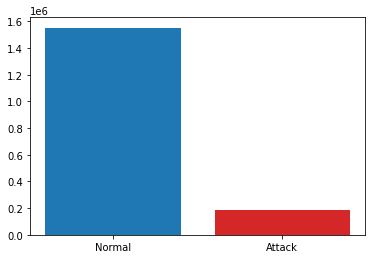

In [43]:
plt.bar(x=["Normal", "Attack"], height=np.bincount(df["Label"]), color=["tab:blue", "tab:red"])
plt.show()

Next, we look at the proportion of the different types of attacks:

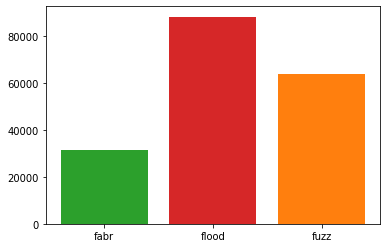

In [44]:
types, types_count = np.unique(df.loc[df["type"] != "none", "type"], return_counts=True)
plt.bar(x=types, height=types_count, color=["tab:green", "tab:red", "tab:orange", "tab:blue"])
plt.show()

It can be seen that there are different amounts of attack types in the dataset.<br>
We want the proportion to be the same after splitting into training and testing data.

Create the training and test data

In [45]:
X_train = df.drop(columns="type")
y_train = df["type"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=y_train)

# # Under-sample on type
# rus = RandomUnderSampler(random_state=0)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# Use feature "Label" as classification label
d_temp: pd.DataFrame = pd.concat([X_train, y_train], axis="columns")
X_train, y_train = d_temp.drop(columns="Label"), d_temp["Label"]
d_temp: pd.DataFrame = pd.concat([X_test, y_test], axis="columns")
X_test, y_test = d_temp.drop(columns="Label"), d_temp["Label"]
d_temp = None # Release memory

Now, we can look at the proportions again (in the Training data):

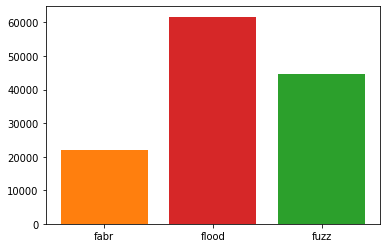

In [46]:
types, types_count = np.unique(X_train.loc[X_train["type"] != "none", "type"], return_counts=True)
plt.bar(x=types, height=types_count, color=["tab:orange", "tab:red", "tab:green", "tab:blue"])
plt.show()

Under-sample the training set by the majority class (no attack, 0). The test set can be left imbalanced, as real world data can also be imbalanced.

In [47]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		128320		465758
Attack		128320		54994


Perform a Chi Squared test to see if there are any features that aren't dependent on the classification label, "Label".

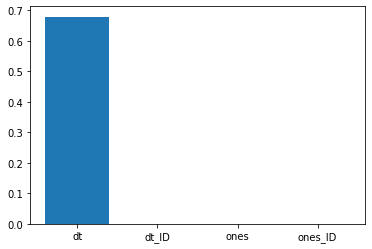

In [48]:
# Use a dataframe without "type", as it is categorical and will not be used to train later
X_train_chi = X_train.drop(columns=["type", "dataset"])
chi_scores = chi2(X_train_chi, y_train)
p_values = chi_scores[1]
plt.bar(x=X_train_chi.columns, height=p_values)
plt.show()
X_train_chi = None # Release memory

I think this shows that the feature "dt" can be dropped as it is not dependent on the class?

Visualize the distribution of attack instances by ones counted.

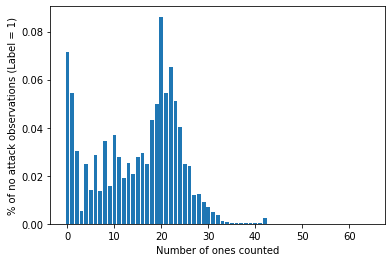

In [49]:
d_temp = pd.concat([X_train, y_train], axis="columns")
size = len(d_temp.loc[d_temp["Label"] == 0].index)
# ones_prob = [[], [], []]
zeros_prob = []
for i in range(65):
    zeros_prob.append(len(d_temp.loc[(d_temp["Label"] == 0) & (d_temp["ones"] == i)].index) / size)

    # prob_flood = len(d_temp.loc[(d_temp["Label"] == 1) & (d_temp["ones"] == i) & (d_temp["type"] == "flood")].index) / size
    # prob_fuzz = len(d_temp.loc[(d_temp["Label"] == 1) & (d_temp["ones"] == i) & (d_temp["type"] == "fuzz")].index) / size
    # prob_fabr = len(d_temp.loc[(d_temp["Label"] == 1) & (d_temp["ones"] == i) & (d_temp["type"] == "fabr")].index) / size
    # ones_prob[0].append(prob_flood)
    # ones_prob[1].append(prob_fuzz)
    # ones_prob[2].append(prob_fabr)


zeros_prob = pd.Series(zeros_prob)
# ones_prob = pd.Series(ones_prob)
# sns.lineplot(data=ones_prob)

# plt.bar(x=range(0, 65), height=ones_prob[0], color="tab:red")
# plt.bar(x=range(0, 65), height=ones_prob[1], color="tab:green")
# plt.bar(x=range(0, 65), height=ones_prob[2], color="tab:orange")
# plt.legend(labels=["Flooding", "Fuzzing", "Fabrication"])
plt.bar(x=range(0, 65), height=zeros_prob)
plt.xlabel("Number of ones counted")
plt.ylabel("% of no attack observations (Label = 1)")
plt.show()

It shows that in the flooding attack, there is never any ones, and it makes up almost 50% of all attacks.<br>
It also shows that the fuzzing attack is randomly generating payloads (as is stated in the paper as well), and since there is a higher chance that a payload will have a one count of 32 (by binomial distribution) the distribution looks the way it does.<br>
It shows that the fabrication attacks have 20 ones, 29 ones or randomly chose (it is the same as fuzzing, just smaller so is not seen well on the graph, but it is seen if plotted separately.).<br>
It shows that 50% of the attacks contain no ones in the payload, so you will catch many attacks going just on that!
Moreover, these attacks have clear patterns by how many ones they contain, as they are either a Specific value (0, 20 or 29).. or... binomially distributed.

Train the Random Forest model with the Training data. First remove the "type" feature as it isn't used in classification.

In [50]:
# ind_temp = X_train[X_train["dataset"] == "Survival"].index
# X_train.drop(index=ind_temp, inplace=True)
# y_train.drop(index=ind_temp, inplace=True)

# ind_temp = X_test[X_test["dataset"] == "Survival"].index
# X_test.drop(index=ind_temp, inplace=True)
# y_test.drop(index=ind_temp, inplace=True)

X_train.drop(columns=["type", "dataset"], inplace=True)
X_test.drop(columns=["type", "dataset"], inplace=True)
clf = RandomForestClassifier(n_estimators=20, random_state=0, max_leaf_nodes=300).fit(X_train, y_train)

Calculate scores:

Training F1: 0.9976 (+/- 0.0004)
Testing F1:  0.9976(+/- 0.0000)
Kappa score:  0.9872(+/- 0.0000)


<AxesSubplot:>

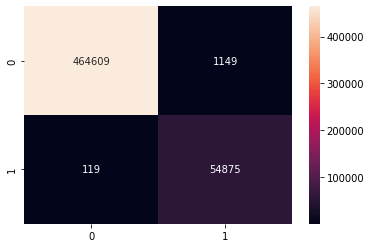

In [59]:
scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=10, n_jobs=-1)
print("Training F1: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

pred = clf.predict(X_test)

f1_scores = f1_score(y_test, pred, average='weighted')
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

cm = confusion_matrix(y_test, pred)
annots = pd.DataFrame(confusion_matrix(y_test, pred)).applymap(str)
sns.heatmap(cm, annot=annots, fmt="s")

# Not under-sampled:    FN=387, FP=286
# Under-sampled:        FN=119, FP=1149
# Under-sampled (type): FN=176, FP=1363